# Twitter Sentiment Analysis with Tensorflow LSTM

This variant of the popular positive/negative sentiment analysis challenge will apply emotion labels to each tweet.  This code is modeled from the tutorial posted here: https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

To start, let's look at some of our data

In [1]:
filename = "text_emotion.csv"

import csv
with open(filename) as inf:
    tweetreader = csv.reader(inf, delimiter=',',quotechar='"')
    
    counter = 0
    for line in tweetreader:
        number, emotion, user, tweet = line
        print(line)
        #print(str(counter) + ':' + emotion + ': ' + tweet)
        counter = 1+counter
        if counter >10: break
        #print(', '.join(line))
        
print(tweet[1:])

['tweet_id', 'sentiment', 'author', 'content']
['1956967341', 'empty', 'xoshayzers', '@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[']
['1956967666', 'sadness', 'wannamama', 'Layin n bed with a headache  ughhhh...waitin on your call...']
['1956967696', 'sadness', 'coolfunky', 'Funeral ceremony...gloomy friday...']
['1956967789', 'enthusiasm', 'czareaquino', 'wants to hang out with friends SOON!']
['1956968416', 'neutral', 'xkilljoyx', '@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']
['1956968477', 'worry', 'xxxPEACHESxxx', "Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends"]
['1956968487', 'sadness', 'ShansBee', "I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"]
['1956968636', 'worry', 'mcsleazy', 'Hmmm. http://www.djhero.com/ is down']
['1956969035', 'sadness', 'nic0lepaula', '@cha

Tweet_ID, followed by a sentiment label, author, and then content.  We're going to need to do some modifications to this data to be able to work with it.  Not all the labels seem perfect.

To start lets set up the system that will turn these words into fancy vectors.

We'll import two numpy data structures to facilitate the processing of our data.  First is a python list of 400,000 words `wordsList.npy` and the second is a list of 400,000 word vectors from the GloVe each with a dimensionality of 50 in `wordVectors.npy`

https://nlp.stanford.edu/projects/glove/


In [2]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list! Total words: ' + str(len(wordsList)))
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(wordVectors.shape)

Loaded the word list! Total words: 400000
Loaded the word vectors!
(400000, 50)


Let's test that our word matrix is a thing by looking for a word

In [3]:
agoraIndex = wordsList.index('agora')
wordVectors[agoraIndex]

array([ 0.39263999, -0.0092266 , -0.13176   ,  0.96239001, -0.062905  ,
       -1.09309995,  0.13189   , -0.024347  , -0.99756998,  0.63986999,
        0.41080001,  0.16771001,  0.29813999,  0.56809998, -0.29468   ,
       -0.016411  ,  0.038173  ,  0.81361002, -0.39416999,  0.84174001,
        0.95032001, -0.81366003, -0.80491   ,  0.36105001,  0.22521   ,
        0.033748  , -1.12300003, -0.28904   , -0.66307998, -0.72391999,
       -0.57380003, -0.30045   , -0.034403  ,  0.53649002, -1.21940005,
       -0.47835001,  0.081912  , -0.091379  ,  0.69239002,  0.99975002,
        0.60606998, -0.90864998, -0.21683   ,  0.81268001, -0.12811001,
        0.22163001, -0.48390999,  0.48424   ,  0.69533002, -0.75996   ], dtype=float32)

Looking sexy to me. 
Now let's test this system works and can generate a location in space with the given vectors

In [4]:
import tensorflow as tf
maxSeqLength = 10 #Maximum length of sentence
firstSentence = np.zeros((maxSeqLength), dtype='int32') #this is template for future codings
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("want")
firstSentence[2] = wordsList.index("to")
firstSentence[3] = wordsList.index("play")
firstSentence[4] = wordsList.index("and")
firstSentence[5] = wordsList.index("work")
firstSentence[6] = wordsList.index("with")
firstSentence[7] = wordsList.index("inspiring")
firstSentence[8] = wordsList.index("people")
#firstSentence[9] are going to be 0 ... since the tensorflow object was initalized with 10 zeros
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[   41   303     4   282     5   161    17 13767    69     0]


In [5]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


## Let's look at our data and load it in

The data we're working with is a .csv file with 40k tweets each labeled with one of 13 emotions:

- anger
- boredom
- empty
- enthusiasm
- fun
- happiness
- hate
- love
- neutral
- relief
- sadness
- surprise
- worry

Dataset is a .csv file with 40k entries of four columns:

| tweet_id | sentiment | author | content |

Let's determine the max size of our input vector so all the tweets will fit

Let's look at a few samples of tweets! to start:


{'empty': 0, 'sadness': 1, 'enthusiasm': 2, 'neutral': 3, 'worry': 4, 'surprise': 5, 'love': 6, 'fun': 7, 'hate': 8, 'happiness': 9, 'boredom': 10, 'relief': 11, 'anger': 12}
{'empty': 826, 'sadness': 5164, 'enthusiasm': 758, 'neutral': 8637, 'worry': 8458, 'surprise': 2186, 'love': 3841, 'fun': 1775, 'hate': 1322, 'happiness': 5208, 'boredom': 178, 'relief': 1525, 'anger': 109}
The total number of tweets is 40000
The total number of words is 528675
The average length of a tweet is 13.216875
The max length of a tweet is: 34


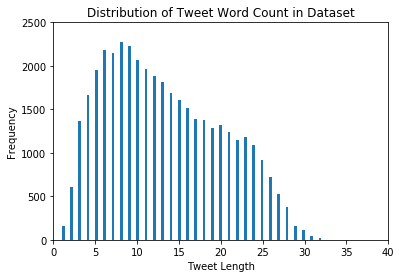

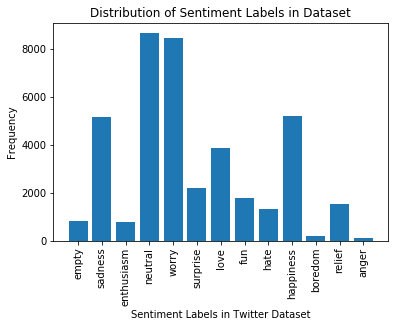

In [6]:
import csv
import copy

filename = "text_emotion.csv"
csv_column_names = ['tweet_id','sentiment','author','content']

sentimentCounter = {}
biggestTweetSize = 0


with open(filename) as inf:
    tweetreader = csv.reader(inf, delimiter=',',quotechar='"')
    next(inf) # skip header
    
### IMPROVMENT: use pandas so I can address the columns by label
    counter = 0
    numWords = []

    for line in tweetreader:
        # Read data, using python, into our features
        number, emotion, user, tweet = line
        
        if emotion in sentimentCounter:
            #print(sentimentCounter[emotion])
            sentimentCounter[emotion] = sentimentCounter[emotion] + 1
            #print(str(emotion) + "+1 = " + str(sentimentCounter[emotion]))
        else:
            sentimentCounter[emotion] = 0
        
        count = len(tweet.split())
        numWords.append(count)
        
        # for k, v in sentimentCounter.items():
        #    if k == emotion:
        #       sentimentCounter[k] = v + 1
        
        counter = counter + 1
        #if counter % 1000: print(sentimentCounter)

# Let's create a new dictionary to use later without the count
# Great reference on shallow or deep copy: https://stackoverflow.com/questions/3975376/understanding-dict-copy-shallow-or-deep

sentimentDictionary = copy.deepcopy(sentimentCounter)
for idx, val in enumerate(sentimentDictionary):
    sentimentDictionary[val] = idx
print(sentimentDictionary)
        
numTweets = len(numWords)
sumTweets = sum(numWords)
print(sentimentCounter)
print('The total number of tweets is', numTweets)
print('The total number of words is', sumTweets)
print('The average length of a tweet is', sumTweets/numTweets)
print('The max length of a tweet is:', max(numWords))

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 100)
plt.title('Distribution of Tweet Word Count in Dataset')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.axis([0, 40, 0, 2500])
plt.show()

plt.bar(range(len(sentimentCounter)), list(sentimentCounter.values()), align='center')
plt.title('Distribution of Sentiment Labels in Dataset')
plt.xlabel('Sentiment Labels in Twitter Dataset')
plt.ylabel('Frequency')
plt.xticks(range(len(sentimentCounter)), list(sentimentCounter.keys()), rotation='vertical')
plt.show()

#print('The total number of words in the files is', sum(int(numTweets)))
#print('The average number of words in the files is', sum(numTweets)/len(numTweets))


### Some conclusions from primary data analysis:
- Sentiment labelling highly skwed.  Many examples for worry, neutral, happiness, and sadness.  Few examples for anger, boredom, empty.  Perhaps this reflective of the entire twitter universe too. Will likely affect the training accuracy for the rare sentiments like anger.
- Distribution of tweet length suggests a vector of 50 should cover all our cases.   
- QUESTION: For this test, we're only working in our data universe so we can reduce mapping by 30% if we drop it to 35.  Since the tweet size has recently been doubled perhaps the average word length would double with the average around 26 and the max around 70?

In [7]:
maxTweetLength = 35

Now let's clean up and load our data.  We'll create a few functions and loop through the csv to create our starting vectors using numpy

#### Tweet Vector
- remove special characters and make all the words lowercase since that is how the word vectors are made
- create a vector with all the words in the word list. we'll use that word list to generate the word vector

#### Sentiment Vector
- create a dictionary with numerical mappings for the emotions
- map the string to an int


#### General
- Save the vector so you don't need to complete run this again!


In [23]:
from tempfile import TemporaryFile
tweetPickle = TemporaryFile()
sentimentPickel = TemporaryFile()

import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())
    
a = sentimentDictionary['happiness']
print('happiness: ' + str(a))

print(sentimentDictionary)
sentimentSize = len(sentimentDictionary)

tweets = np.zeros((numTweets, maxTweetLength), dtype='int32')
sentiments = np.zeros((numTweets, len(sentimentDictionary)), dtype='int32')


print(np.shape(tweets), np.shape(sentiments))



happiness: 9
{'empty': 0, 'sadness': 1, 'enthusiasm': 2, 'neutral': 3, 'worry': 4, 'surprise': 5, 'love': 6, 'fun': 7, 'hate': 8, 'happiness': 9, 'boredom': 10, 'relief': 11, 'anger': 12}
(40000, 35) (40000, 13)


In [14]:
##### HEADS UP #####
Instead of running that code above you can just run the next section to import the pickles

SyntaxError: invalid syntax (<ipython-input-14-88403026fbea>, line 2)

In [13]:
with open(filename) as inf:
    tweetreader = csv.reader(inf, delimiter=',',quotechar='"')
    tweetCounter = 0
    
    testing = 40001
    printCheckpoint = 1000
    
    next(inf) # skip header
#    print(sentimentDictionary)
    
### IMPROVMENT: use pandas so I can address the columns by label
    
    for line in tweetreader:
        number, emotion, user, tweet = line
        cleanTweet = cleanSentences(tweet)
        splitTweet = cleanTweet.split()
        wordCounter = 0
        
        for word in splitTweet:
            try:
                tweets[tweetCounter][wordCounter] = wordsList.index(word)
            except ValueError:
                tweets[tweetCounter][wordCounter] = 399999 #Vector for unkown words
            wordCounter = wordCounter + 1
            if wordCounter >= maxTweetLength: break ## maxTweetLength = 50
        
        sentimentMap = sentimentDictionary[emotion]
        sentiments[tweetCounter][sentimentMap] = 1
        #print(sentiments[tweetCounter])
                    
        if tweetCounter%printCheckpoint == 0: 
        #    print("\t" + str(sentimentMap) + "\t" + str(emotion))
            print('Tweet:' + str(tweetCounter) + ': ' + str(emotion) + '\t' + str(sentimentMap))
            print(sentiments[tweetCounter])
            #     print(cleanTweet)
        if tweetCounter > testing: break
            
        tweetCounter = tweetCounter + 1


#print(tweets)
print(sentiments[:10])
            
np.save('tweetVector', tweets, allow_pickle=True)
np.save('sentimentVector', sentiments, allow_pickle=True)

Tweet:0: empty	0
[1 0 0 0 0 0 0 0 0 0 0 0 0]
Tweet:1000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:2000: sadness	1
[0 1 0 0 0 0 0 0 0 0 0 0 0]
Tweet:3000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:4000: neutral	3
[0 0 0 1 0 0 0 0 0 0 0 0 0]
Tweet:5000: sadness	1
[0 1 0 0 0 0 0 0 0 0 0 0 0]
Tweet:6000: neutral	3
[0 0 0 1 0 0 0 0 0 0 0 0 0]
Tweet:7000: neutral	3
[0 0 0 1 0 0 0 0 0 0 0 0 0]
Tweet:8000: sadness	1
[0 1 0 0 0 0 0 0 0 0 0 0 0]
Tweet:9000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:10000: love	6
[0 0 0 0 0 0 1 0 0 0 0 0 0]
Tweet:11000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:12000: happiness	9
[0 0 0 0 0 0 0 0 0 1 0 0 0]
Tweet:13000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:14000: neutral	3
[0 0 0 1 0 0 0 0 0 0 0 0 0]
Tweet:15000: surprise	5
[0 0 0 0 0 1 0 0 0 0 0 0 0]
Tweet:16000: hate	8
[0 0 0 0 0 0 0 0 1 0 0 0 0]
Tweet:17000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:18000: worry	4
[0 0 0 0 1 0 0 0 0 0 0 0 0]
Tweet:19000: sadness	1
[0 1 0 0 0 0 0 0 0 0 0 0 0]
Tweet:20000:

In [15]:
tweets = np.load('tweetVector.npy', mmap_mode='r')
sentiments = np.load('sentimentVector.npy', mmap_mode='r')

### Splitting the data into a training and test set
We want to use a portion of our data for training the network and a remaining portion for the testing and validation.  The following code will create those two datasets

OPPORTUNITY FOR IMPROVEMENT:
- look at the existing numpy/tensorflow codebase to see what formulas can be used to speed up this process
- try list comprehension wrapped around a generator expression
- confirm all the sentiments are represented in the testing dataset / or in similar distribution
- learn more about reading files https://learningtensorflow.com/ReadingFilesBasic/


In [19]:
batchSize = 24

def splitData(data, testRatio=0.1 ):
    trainingData = []
    testingData = []
    
    numElements = len(data)
    testingSize = int(numElements * testRatio)
    trainingSize = numElements - testingSize
    #print(testingSize, trainingSize)

    for i, item in enumerate(data):
        #print(i, item)
        if i < trainingSize:
            trainingData.append(item)
        else: 
            testingData.append(item)
    
    print("Input data size: " + str(numElements))
    print("Output Training Data size: " + str(len(trainingData)))
    print("Output Testing Data size: " + str(len(testingData)))
    
    return trainingData, testingData

experiment = [1,2,3,4,5,6,7,8,9,10]

result1, result2 = splitData(experiment, 0.2)
print(result1)
print(result2)

Input data size: 10
Output Training Data size: 8
Output Testing Data size: 2
[1, 2, 3, 4, 5, 6, 7, 8]
[9, 10]


In [22]:
testRatio = .1       #10% of the training data will be used for validation

tweetTraining, tweetTesting = splitData(tweets, testRatio)
sentimentTraining, sentimentTesting = splitData(sentiments, testRatio)



tweetTrainingSize = len(tweetTraining)
tweetTestingSize = len(tweetTesting)
sentimentTrainingSize = len(sentimentTraining)
sentimentTestingSize = len(sentimentTesting)

#print(sentimentTestingSize)

Input data size: 40000
Output Training Data size: 36000
Output Testing Data size: 4000
Input data size: 40000
Output Training Data size: 36000
Output Testing Data size: 4000


#### Helper Functions
We will be making data batches to optimize our network with

I made something that works.  This is a blog with information http://ischlag.github.io/2016/06/19/tensorflow-input-pipeline-example/ for future data pipeline references

In [25]:
from random import randint

def getDataBatch(data,label):
    arr = np.zeros([batchSize, maxSeqLength])
    lab = np.zeros([batchSize, sentimentSize])
    
    batchData = []
    batchLabels = []
    
    dataSize = len(data)
        
    if len(data) != len(label):
        print("Data size does not match. Check the size of the data")
        
    for i in range(batchSize):
        num = randint(1,dataSize-1)
        batchData.append(data[num])
        batchLabels.append(label[num])
    return batchData, batchLabels

testData = [1,2,3,4,5,6,7,8,9,10]
testLabel = [11,12,13,14,15,16,17,18,19,20]

oneResult, twoResult = getDataBatch(testData, testLabel)
print(oneResult)
print(twoResult)

[3, 9, 2, 8, 7, 9, 6, 3, 7, 2, 5, 4, 6, 3, 5, 8, 2, 9, 7, 3, 5, 5, 6, 10]
[13, 19, 12, 18, 17, 19, 16, 13, 17, 12, 15, 14, 16, 13, 15, 18, 12, 19, 17, 13, 15, 15, 16, 20]


### Now let's start doing the TensorFlow part!

We need to define a few variables to get this started
- **batchSize**: the number of samples to be shown to the network before a weight update can be performed. We'll start with a batchSize of 24 to allow for faster learning, then copy the weights to our predictor network and change the batchSize to 1 to allow individual tweet sentiment predictions
- **lstmUnits**: the number of hidden LSTM neurons. 64 choosen from the tutorial ... I can fine tune this
- **numClasses**: equal to the number of sentiments
- **iterations**: how many times the system will loop to reduce error and train
- **numDimensions**: the number of dimensions for each word vector

In [26]:
batchSize = 24
lstmUnits = 64
numClasses = sentimentSize #13
iterations = 100000
numDimensions = 50  

In [27]:
import tensorflow as tf
tf.reset_default_graph()

print("numClasses:" + str(numClasses))
print("batchSize:" + str(batchSize))
print("maxTweetLength:" + str(maxTweetLength))

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxTweetLength])

# A TensorFlow placeholder is the object that data is fed into during training

numClasses:13
batchSize:24
maxTweetLength:35


In [28]:
data = tf.Variable(tf.zeros([batchSize, maxTweetLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [29]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])  #transposes the tf object over the diagonal - swap vectical (0) and horizontal (1)
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

## Tensorboard for Visulalizing
Tensorboard is a visualization package for Tensorflow. It makes pretty interactive output. 

To view go to your termiinal and enter `tensorboard --logdir=tensorboard`, and then visit http://localhost:6006/ with a browser to keep an eye on your training progress.


### FIX ERROR:
- Error! /Users/.../ml/models/pretrained_lstm.ckpt-10000.data-00000-of-00001 is not UTF-8
- Saving Distabled
- See Console for more details


In [24]:
import datetime

sess = tf.InteractiveSession() # as opposed to while sess open
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getDataBatch(tweetTraining,sentimentTraining)
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

SyntaxError: invalid syntax (<ipython-input-24-d493460cff53>, line 4)

# Incomplete:
- This is how far I got in the project at this point the following is a list of tasks remaining.
- I got stuck on saving the network

## Testing the network

Now that the network is trained, we can test it with the remaining 10% of data that we did not use to train. 

- Load trained network
- Pass data and evaluate

### Some graphs to make:
- Plot energy function
- compare learning rates on accuracy
- collection of examples (good, okay, bad)

In [30]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxTweetLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.25)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))


In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

## Data Analysis
- Plot energy function
- compare learning rates on accuracy
- collection of examples (good, okay, bad)